# Construire un pipeline d'exécution avec PostgreSQL

## Configuration initiale :

Nous devons avoir Docker installé car nous utiliserons la procédure "Exécution d'Airflow dans Docker" pour cet exemple. Les étapes ci-dessous devraient être suffisantes, mais consultez la documentation de démarrage rapide pour des instructions complètes.

In [ ]:
#Télécharger le fichier docker-compose.yaml
curl -LfO 'https://airflow.apache.org/docs/apache-airflow/stable/docker-compose.yaml'

#Créer les répertoires attendus et définir une variable d'environnement attendue
mkdir -p ./dags ./logs ./plugins
echo -e "AIRFLOW_UID=$(id -u)" > .env

#Initialiser la base de données
docker-compose up airflow-init

#Démarrer tous les services
docker-compose up

Une fois que tous les services ont été démarrés, l'interface utilisateur Web sera disponible à l'adresse : http://localhost:8080. Le compte par défaut a le nom d'utilisateur airflow et le mot de passe airflow. 

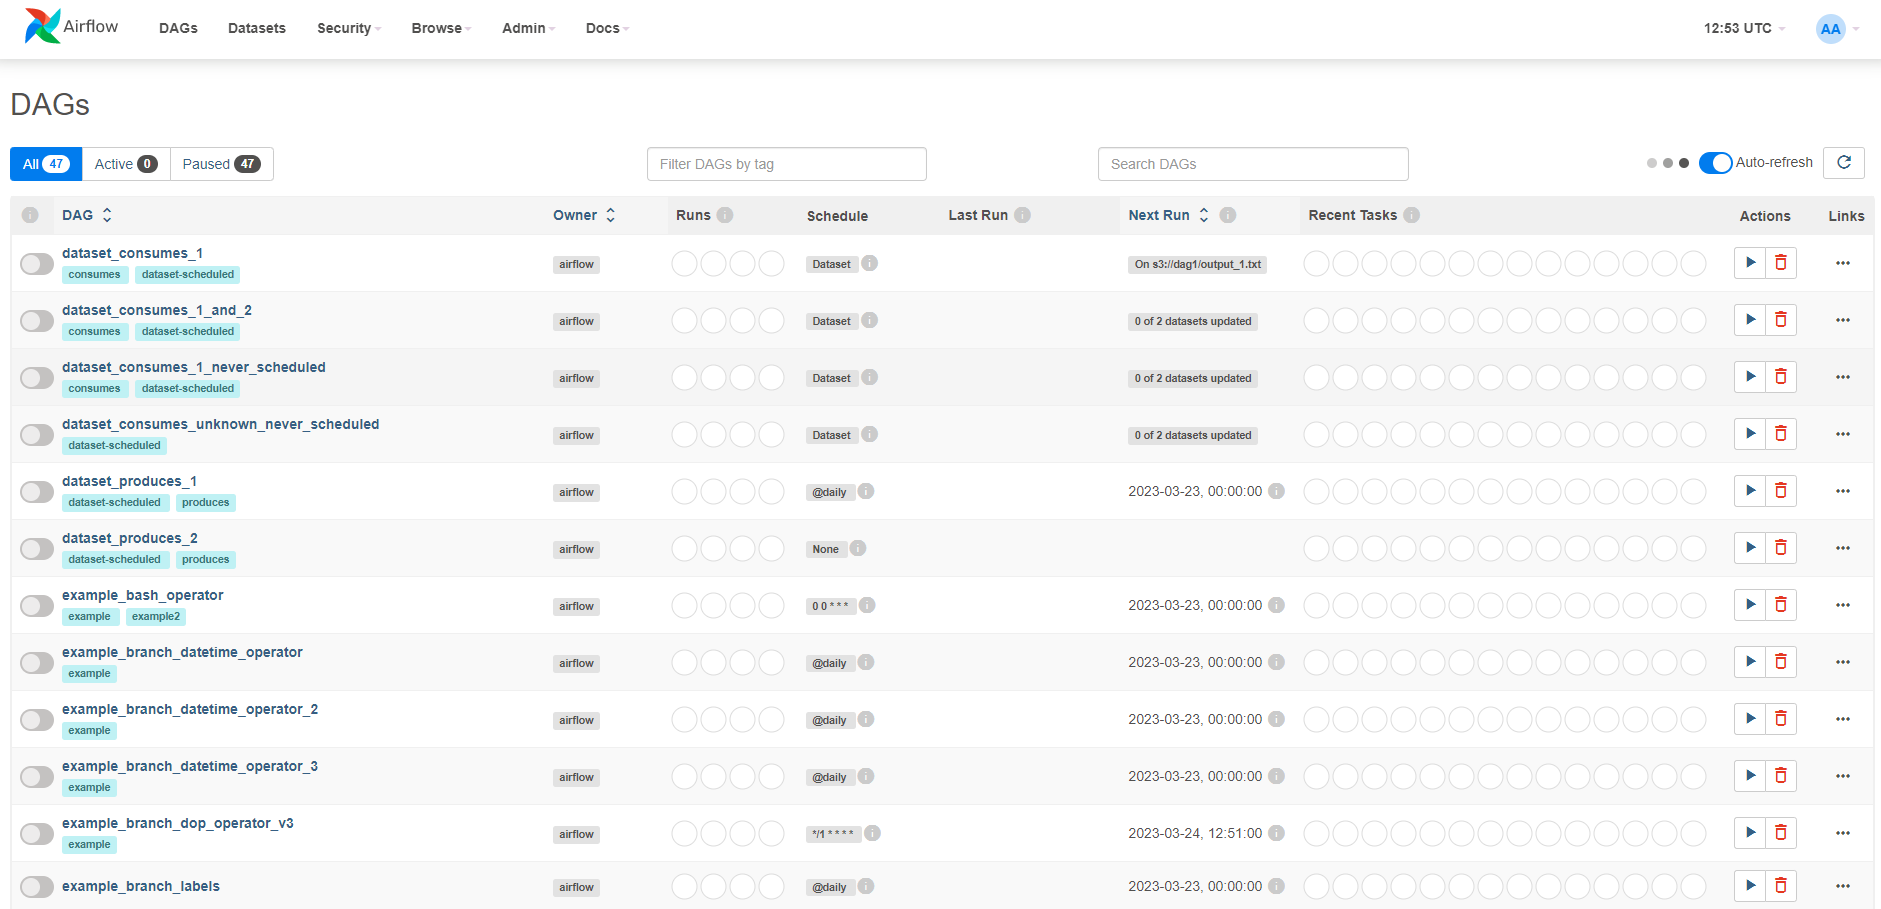

Nous devrons également créer une connexion à la base de données postgres. Pour en créer une via l'interface Web, dans le menu "Admin", sélectionnez "Connections", puis cliquez sur le signe plus pour "Ajouter un nouvel enregistrement" à la liste des connexions.

Remplissez les champs comme indiqué ci-dessous. Notez la valeur de l'identifiant de connexion (Connection Id), que nous passerons en paramètre pour l'argument nommé postgres_conn_id.

Connection Id : tutorial_pg_conn

Type de connexion : postgres

Hôte : postgres

Schéma : airflow

Identifiant : airflow

Mot de passe : airflow

Port : 5432

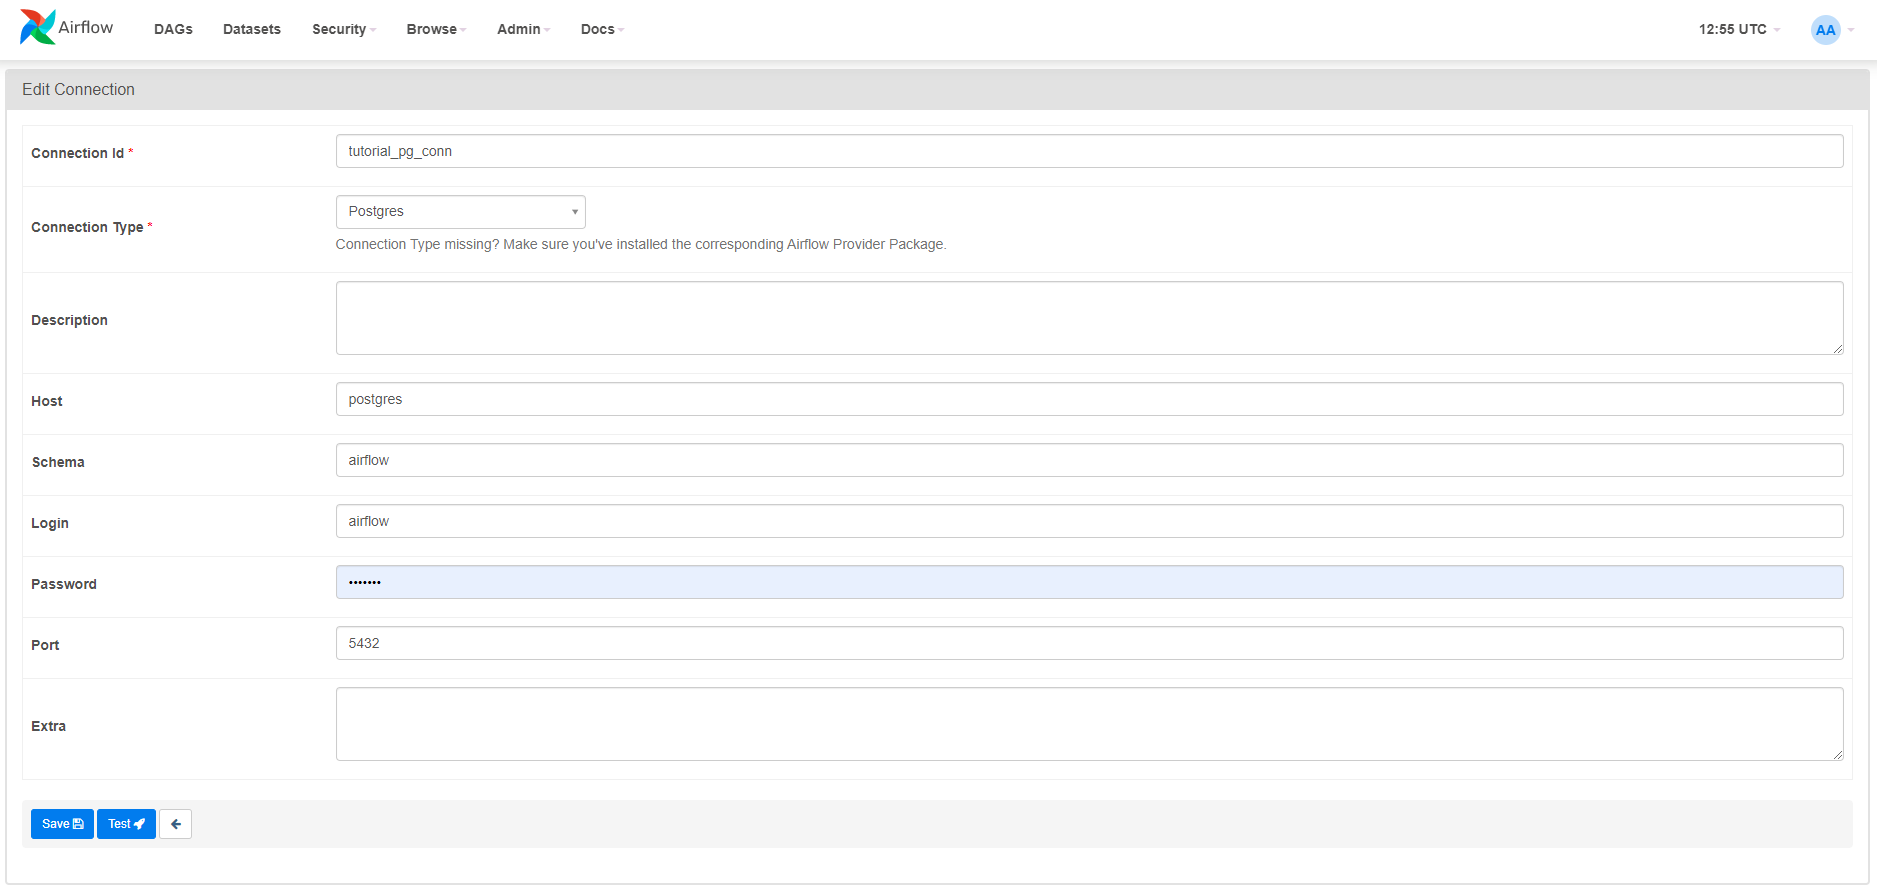

## Tâches de création de table

Nous pouvons utiliser PostgresOperator pour définir des tâches qui créent des tables dans notre base de données postgres.

Nous allons créer une table pour faciliter les étapes de nettoyage des données (employees_temp) et une autre table pour stocker nos données nettoyées (employees).

In [ ]:
from airflow.providers.postgres.operators.postgres import PostgresOperator

create_employees_table = PostgresOperator(
    task_id="create_employees_table",
    postgres_conn_id="tutorial_pg_conn",
    sql="""
        CREATE TABLE IF NOT EXISTS employees (
            "Serial Number" NUMERIC PRIMARY KEY,
            "Company Name" TEXT,
            "Employee Markme" TEXT,
            "Description" TEXT,
            "Leave" INTEGER
        );""",
)

create_employees_temp_table = PostgresOperator(
    task_id="create_employees_temp_table",
    postgres_conn_id="tutorial_pg_conn",
    sql="""
        DROP TABLE IF EXISTS employees_temp;
        CREATE TABLE employees_temp (
            "Serial Number" NUMERIC PRIMARY KEY,
            "Company Name" TEXT,
            "Employee Markme" TEXT,
            "Description" TEXT,
            "Leave" INTEGER
        );""",
)

## Tâche de récupération de données

Ici, nous récupérons les données, les enregistrons dans un fichier sur notre instance Airflow, et chargeons les données à partir de ce fichier dans une table intermédiaire où nous pouvons exécuter les étapes de nettoyage des données.

In [ ]:
import os
import requests
from airflow.decorators import task
from airflow.providers.postgres.hooks.postgres import PostgresHook


@task
def get_data():
    # REMARQUE : configurez cela selon les besoins de votre environnement Airflow.
    data_path = "/opt/airflow/dags/files/employees.csv"
    os.makedirs(os.path.dirname(data_path), exist_ok=True)

    url = "https://raw.githubusercontent.com/apache/airflow/main/docs/apache-airflow/tutorial/pipeline_example.csv"

    response = requests.request("GET", url)

    with open(data_path, "w") as file:
        file.write(response.text)

    postgres_hook = PostgresHook(postgres_conn_id="tutorial_pg_conn")
    conn = postgres_hook.get_conn()
    cur = conn.cursor()
    with open(data_path, "r") as file:
        cur.copy_expert(
            "COPY employees_temp FROM STDIN WITH CSV HEADER DELIMITER AS ',' QUOTE '\"'",
            file,
        )
    conn.commit()

## Tâche de fusion de données
Ici, nous sélectionnons des enregistrements complètement uniques à partir des données récupérées, puis nous vérifions si des numéros de série d'employés sont déjà dans la base de données (s'ils le sont, nous mettons à jour ces enregistrements avec les nouvelles données).

In [ ]:
from airflow.decorators import task
from airflow.providers.postgres.hooks.postgres import PostgresHook


@task
def merge_data():
    query = """
        INSERT INTO employees
        SELECT *
        FROM (
            SELECT DISTINCT *
            FROM employees_temp
        ) t
        ON CONFLICT ("Serial Number") DO UPDATE
        SET
              "Employee Markme" = excluded."Employee Markme",
              "Description" = excluded."Description",
              "Leave" = excluded."Leave";
    """
    try:
        postgres_hook = PostgresHook(postgres_conn_id="tutorial_pg_conn")
        conn = postgres_hook.get_conn()
        cur = conn.cursor()
        cur.execute(query)
        conn.commit()
        return 0
    except Exception as e:
        return 1

## Finalisation de notre DAG

Nous avons développé nos tâches, maintenant nous devons les envelopper dans un DAG, qui nous permet de définir quand et comment les tâches doivent s'exécuter, et d'indiquer les dépendances que les tâches ont sur d'autres tâches. Le DAG ci-dessous est configuré pour :

* s'exécuter tous les jours à minuit à partir du 24er mars 2023,

* ne s'exécuter qu'une seule fois en cas de jours manqués, et

* s'interrompre après 60 minutes.

Et à partir de la dernière ligne de la définition du DAG "process-employees", nous voyons :

In [ ]:
[create_employees_table, create_employees_temp_table] >> get_data() >> merge_data()

* la tâche "merge_data()" dépend de la tâche "get_data()",

* "get_data()" dépend à la fois des tâches "create_employees_table" et "create_employees_temp_table",

* et les tâches "create_employees_table" et "create_employees_temp_table" peuvent s'exécuter indépendamment.

En mettant tous les éléments ensemble, nous avons notre DAG finalisé.

In [ ]:
import datetime
import pendulum
import os

import requests
from airflow.decorators import dag, task
from airflow.providers.postgres.hooks.postgres import PostgresHook
from airflow.providers.postgres.operators.postgres import PostgresOperator


@dag(
    dag_id="process-employees",
    schedule_interval="0 0 * * *",
    start_date=pendulum.datetime(2021, 1, 1, tz="UTC"),
    catchup=False,
    dagrun_timeout=datetime.timedelta(minutes=60),
)
def ProcessEmployees():
    create_employees_table = PostgresOperator(
        task_id="create_employees_table",
        postgres_conn_id="tutorial_pg_conn",
        sql="""
            CREATE TABLE IF NOT EXISTS employees (
                "Serial Number" NUMERIC PRIMARY KEY,
                "Company Name" TEXT,
                "Employee Markme" TEXT,
                "Description" TEXT,
                "Leave" INTEGER
            );""",
    )

    create_employees_temp_table = PostgresOperator(
        task_id="create_employees_temp_table",
        postgres_conn_id="tutorial_pg_conn",
        sql="""
            DROP TABLE IF EXISTS employees_temp;
            CREATE TABLE employees_temp (
                "Serial Number" NUMERIC PRIMARY KEY,
                "Company Name" TEXT,
                "Employee Markme" TEXT,
                "Description" TEXT,
                "Leave" INTEGER
            );""",
    )

    @task
    def get_data():
        # REMARQUE : configurez cela selon les besoins de votre environnement Airflow.
        data_path = "/opt/airflow/dags/files/employees.csv"
        os.makedirs(os.path.dirname(data_path), exist_ok=True)

        url = "https://raw.githubusercontent.com/apache/airflow/main/docs/apache-airflow/tutorial/pipeline_example.csv"

        response = requests.request("GET", url)

        with open(data_path, "w") as file:
            file.write(response.text)

        postgres_hook = PostgresHook(postgres_conn_id="tutorial_pg_conn")
        conn = postgres_hook.get_conn()
        cur = conn.cursor()
        with open(data_path, "r") as file:
            cur.copy_expert(
                "COPY employees_temp FROM STDIN WITH CSV HEADER DELIMITER AS ',' QUOTE '\"'",
                file,
            )
        conn.commit()

    @task
    def merge_data():
        query = """
            INSERT INTO employees
            SELECT *
            FROM (
                SELECT DISTINCT *
                FROM employees_temp
            ) t
            ON CONFLICT ("Serial Number") DO UPDATE
            SET "Serial Number" = excluded."Serial Number";
        """
        try:
            postgres_hook = PostgresHook(postgres_conn_id="tutorial_pg_conn")
            conn = postgres_hook.get_conn()
            cur = conn.cursor()
            cur.execute(query)
            conn.commit()
            return 0
        except Exception as e:
            return 1

    [create_employees_table, create_employees_temp_table] >> get_data() >> merge_data()


dag = ProcessEmployees()

Enregistrez ce code dans un fichier python dans le dossier /dags (par exemple dags/process-employees.py) et (après une courte attente), le DAG process-employees sera inclus dans la liste des DAG disponibles sur l'interface utilisateur web.



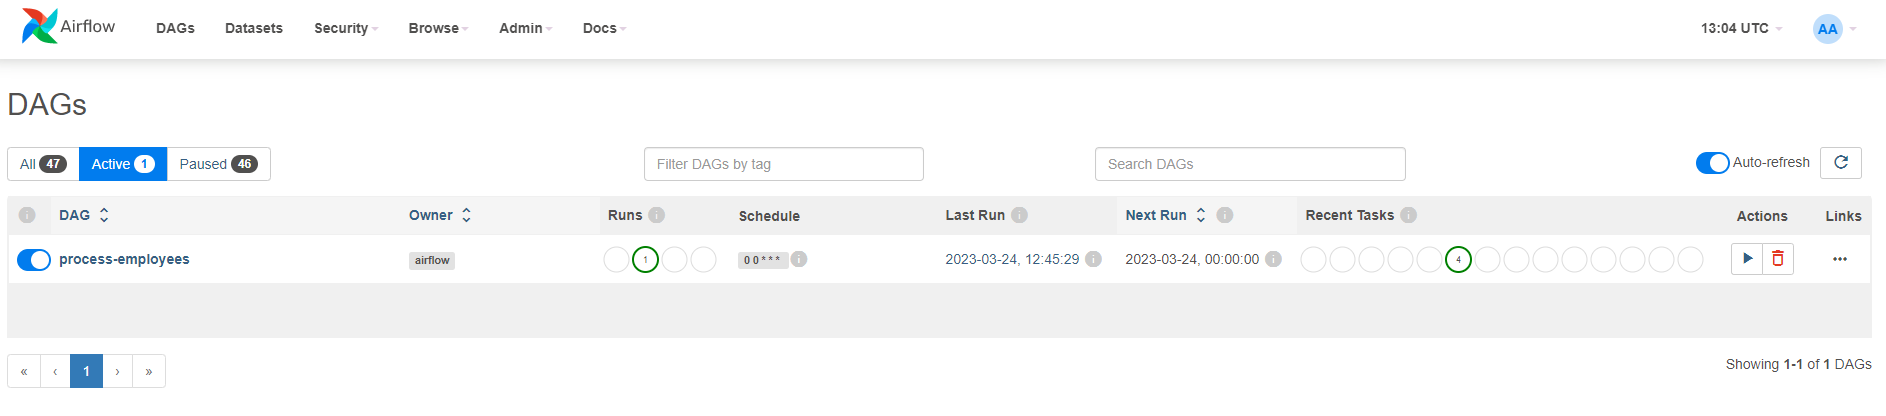

Vous pouvez déclencher le DAG process-employees en le reprenant (via le curseur à l'extrémité gauche) et en le lançant (via le bouton Exécuter sous Actions).

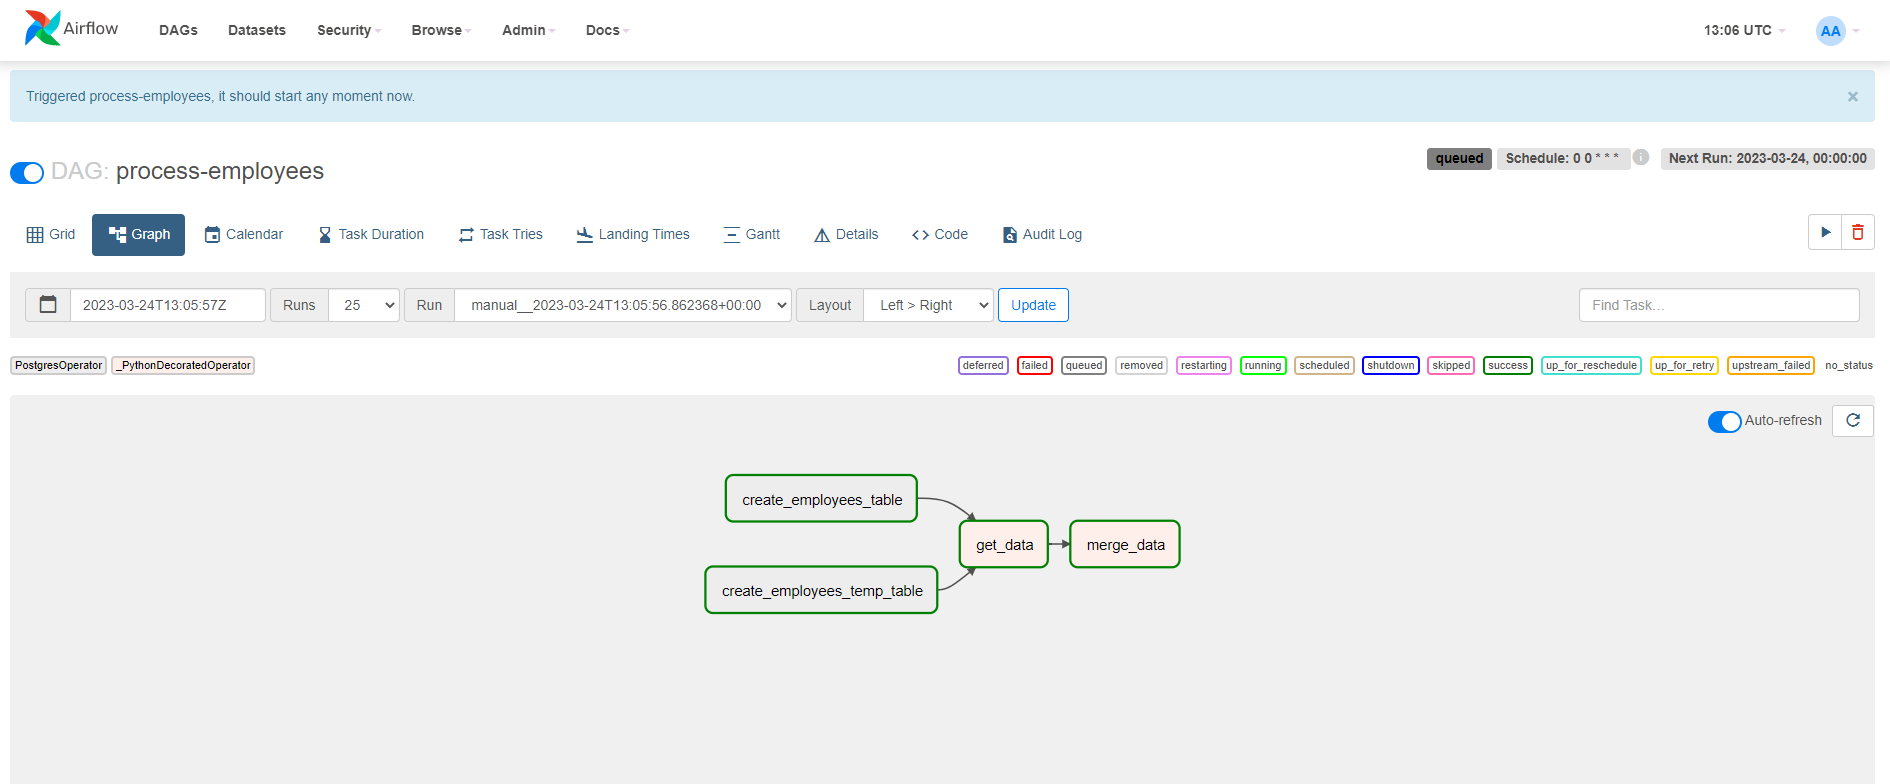

Dans la vue en grille du DAG process-employees, nous constatons que toutes les tâches se sont exécutées avec succès lors de toutes les exécutions réalisées. Succès !

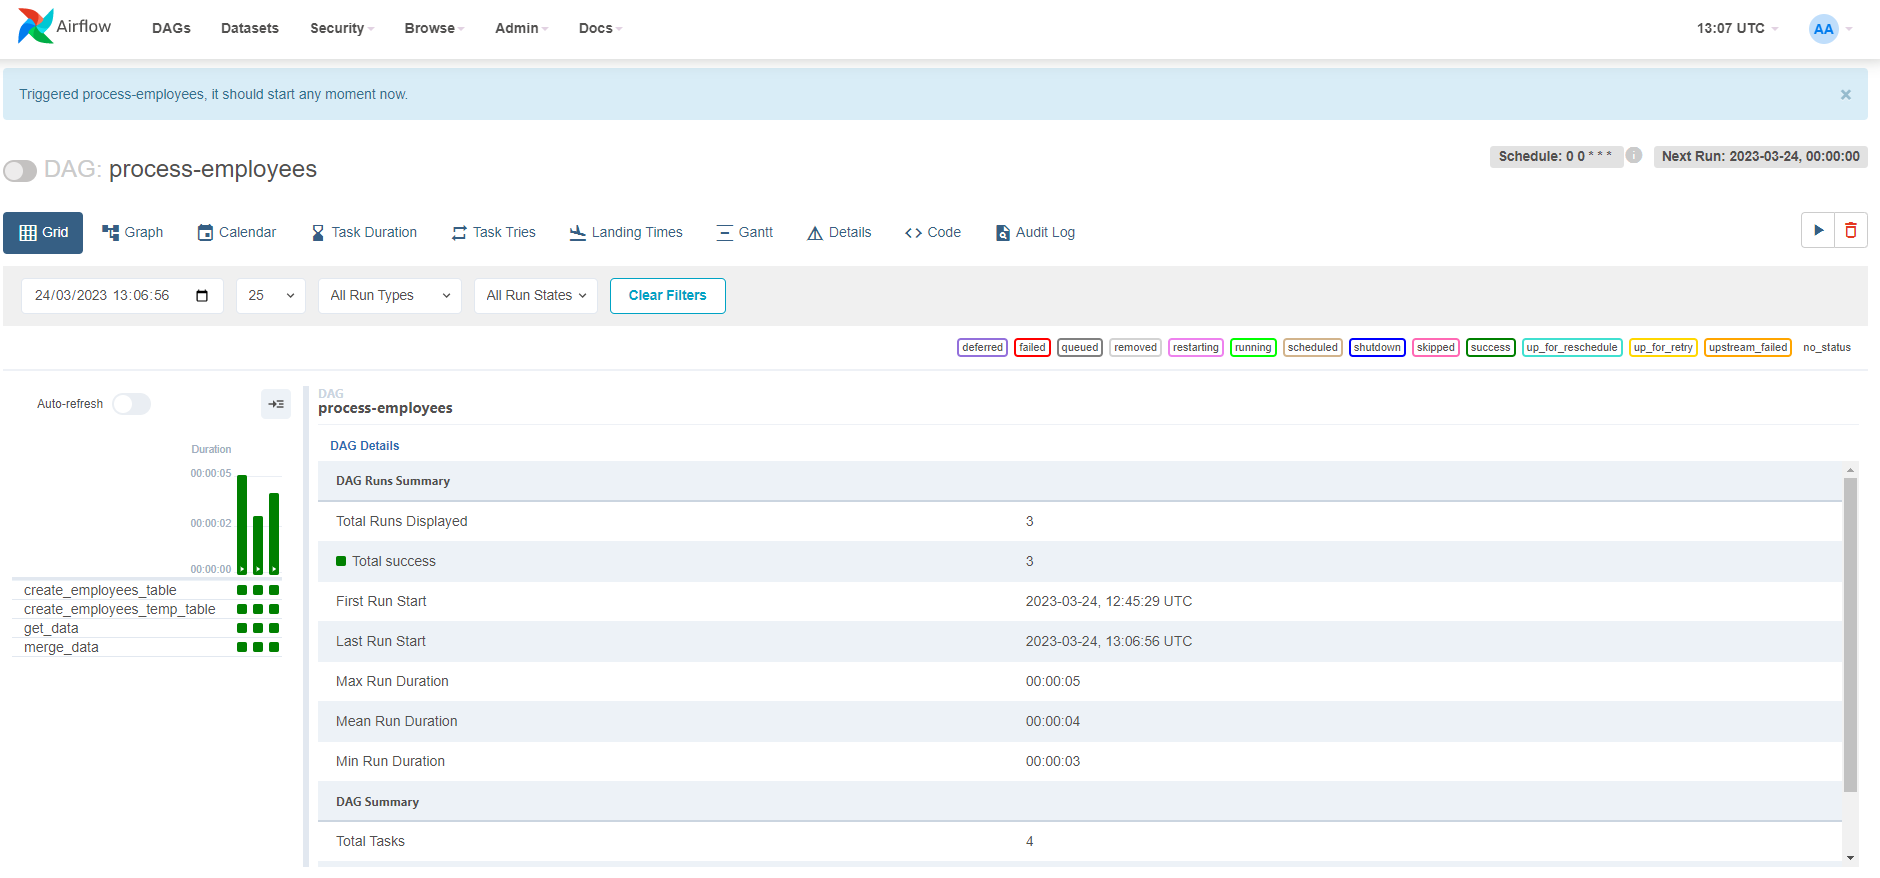